- data_1901_2004_classified_2 -> 이상치 처리 -> data_1901_2004_classified_2_outliered

# 데이터 불러오기

In [14]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams['font.family']=['NanumGothic', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False

df = pd.read_feather('./data/data_1901_2004_classified_2.ftr') # 88656835 rows
df.drop(columns=['index'], inplace=True)
df

,년,월,가맹점소재지1,가맹점소재지2,성별,연령대별,연평균소득추정,이용금액,이용건수,업종
0,2019,1,0,3,1,3,3,1070000.0,4,3
1,2019,1,0,3,0,0,3,48000.0,4,1
2,2019,1,0,3,0,4,5,735000.0,4,17
3,2019,1,0,3,0,2,5,1041289.0,16,2
4,2019,1,0,3,1,3,5,426766.0,13,2
...,...,...,...,...,...,...,...,...,...,...
88656830,2020,4,16,183,1,4,6,303000.0,17,12
88656831,2020,4,16,183,1,5,0,100000.0,5,12
88656832,2020,4,16,183,1,5,3,89000.0,7,12
88656833,2020,4,16,183,1,5,4,636000.0,29,12


  0%|          | 0/18 [00:00<?, ?it/s]

업종:  3


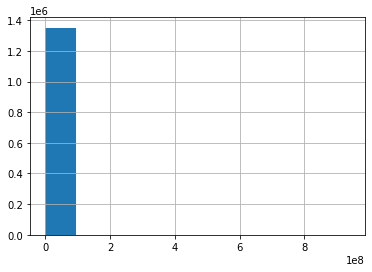

  6%|▌         | 1/18 [00:00<00:08,  2.09it/s]

업종:  1


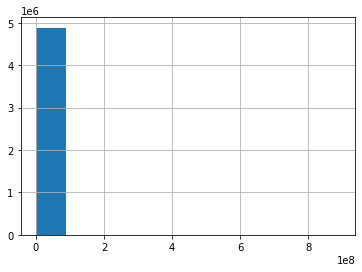

 11%|█         | 2/18 [00:01<00:08,  1.79it/s]

업종:  17


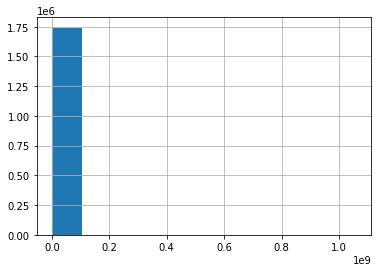

 17%|█▋        | 3/18 [00:01<00:07,  2.04it/s]

업종:  2


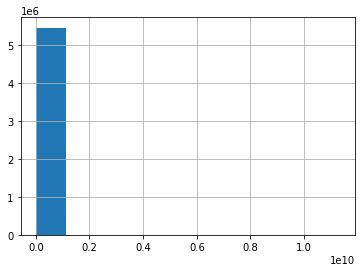

 22%|██▏       | 4/18 [00:02<00:07,  1.81it/s]

업종:  16


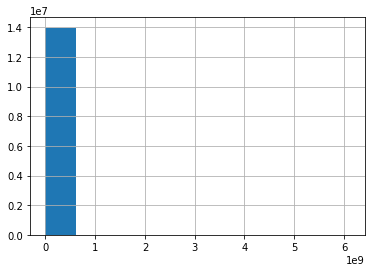

 28%|██▊       | 5/18 [00:03<00:09,  1.34it/s]

업종:  9


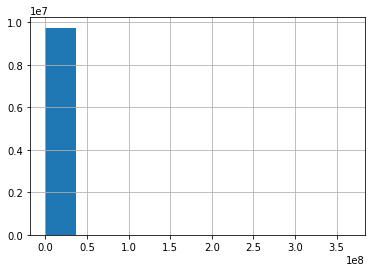

 33%|███▎      | 6/18 [00:04<00:09,  1.25it/s]

업종:  6


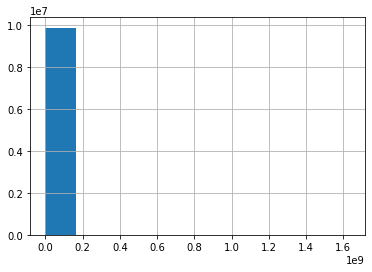

 39%|███▉      | 7/18 [00:05<00:09,  1.19it/s]

업종:  12


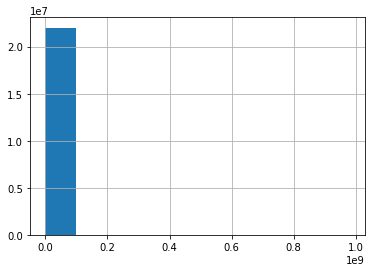

 44%|████▍     | 8/18 [00:06<00:10,  1.03s/it]

업종:  4


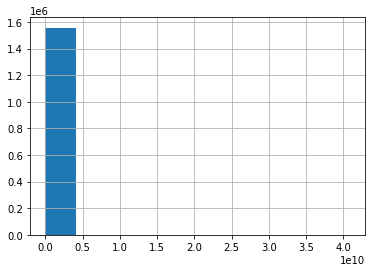

 50%|█████     | 9/18 [00:06<00:07,  1.18it/s]

업종:  5


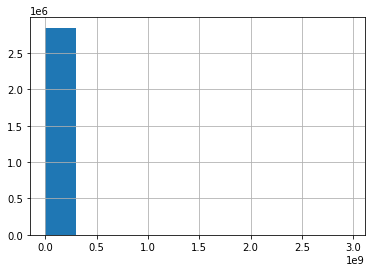

 56%|█████▌    | 10/18 [00:07<00:05,  1.37it/s]

업종:  11


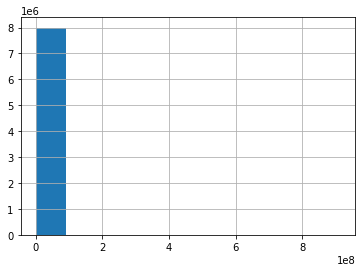

 61%|██████    | 11/18 [00:08<00:05,  1.34it/s]

업종:  0


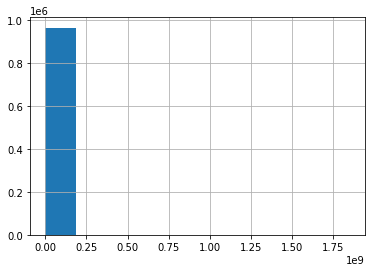

 67%|██████▋   | 12/18 [00:08<00:03,  1.56it/s]

업종:  13


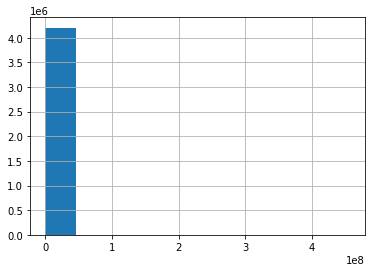

 72%|███████▏  | 13/18 [00:09<00:03,  1.62it/s]

업종:  8


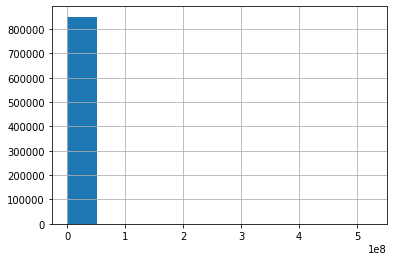

 78%|███████▊  | 14/18 [00:09<00:02,  1.93it/s]

업종:  15


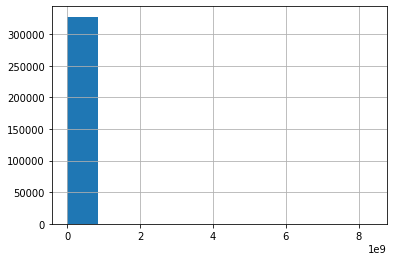

 83%|████████▎ | 15/18 [00:09<00:01,  2.34it/s]

업종:  14


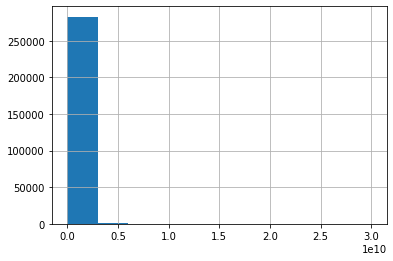

 89%|████████▉ | 16/18 [00:09<00:00,  2.79it/s]

업종:  10


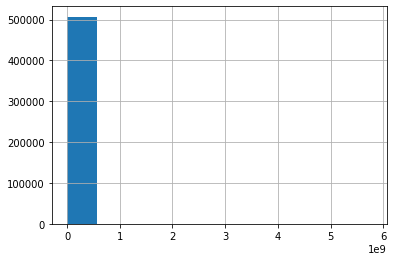

 94%|█████████▍| 17/18 [00:10<00:00,  3.13it/s]

업종:  7


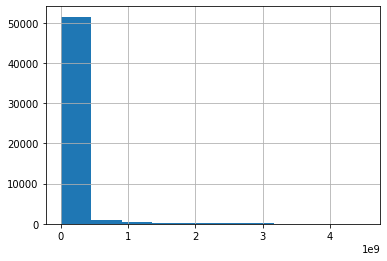

100%|██████████| 18/18 [00:10<00:00,  1.75it/s]


In [15]:
# 업종별 분포 skewness 확인 

from scipy.stats import skew

skewness_list = []

for i in tqdm(df['업종'].unique()):  # 0,1,2, ..., 17

  df_one = df[df['업종'] == i]
  skewness_list.append(skew(df_one['이용금액']))

  print('업종: ', i)
  
  df_one['이용금액'].hist()
  plt.show()


In [17]:
np.mean(skewness_list)

66.54387011385404

# 고객그룹별 이상치 처리 (IQR)
- right-skewed 이므로, 먼저 로그변환 후 이상치처리 후 원상복구
- df['이용금액'] = np.log1p( '이용금액' )
- df['이용금액'] = np.exp1p( '이용금액' )
- index apply + 빌트인 IQR 함수 ---> ㄴㄴ 업종 18개 별로 따로 돌려서 다 합치기

In [5]:
from collections import Counter 

def detect_outliers(df,features): # detect_outliers(df, n, features)
  
  outlier_indices = [] 
  for col in features: 
    Q1 = np.percentile(df[col], 25) 
    Q3 = np.percentile(df[col], 75) 
    IQR = Q3 - Q1 
    
    outlier_step = 1.5 * IQR 
    
    outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index 
    outlier_indices.extend(outlier_list_col) 
  outlier_indices = Counter(outlier_indices) 
  multiple_outliers = list(k for k, v in outlier_indices.items())  # list(k for k, v in outlier_indices.items() if v > n) 
  
  return multiple_outliers 
  
#Outliers_to_drop = detect_outliers(df, 2, ["이용금액"])

In [ ]:
count_list = []

for i in tqdm(df['업종'].unique()): # 0,1,2, ..., 17 

  count=0

  df_one = df[df['업종'] == i]

  print('---')
  print('data len: ', len(df_one))

  grouped = df_one.groupby(by=['년', '월', '가맹점소재지1','가맹점소재지2','성별','연령대별','연평균소득추정', '업종'])

  all_data = []

  for name, group in grouped:

    input = np.log1p(pd.DataFrame(group['이용금액'])) # 로그 변환한 이용금액 col
    Outliers_to_drop = detect_outliers(input, ["이용금액"]) # outlier 의 index

    count += len(Outliers_to_drop)

    dropped = pd.DataFrame(group['이용금액']).drop(Outliers_to_drop, axis = 0) # outlier 삭제된 이용금액 col (원본 index 유지)
    group_ = group.drop(columns=['이용금액'])

    all_data.append(   pd.concat([group_, dropped],axis=1, join='inner')   )

  print('outlier 개수: ', count)
  count_list.append(count)

  df_outliered = pd.concat(all_data, axis=0) # ignore_index=True
  df_outliered = df_outliered.reset_index()
  df_outliered.to_feather(data_dir + 'outlier/outliered_{}.ftr'.format(i))

pd.DataFrame(count_list).to_csv(data_dir + 'outlier/count_list.csv')

  0%|          | 0/18 [00:00<?, ?it/s]

---
data len:  1351855
outlier 개수:  47836


  6%|▌         | 1/18 [08:32<2:25:07, 512.19s/it]

---
data len:  4885557
outlier 개수:  59135


 11%|█         | 2/18 [25:33<3:36:30, 811.92s/it]

---
data len:  1742344
outlier 개수:  51773


 17%|█▋        | 3/18 [43:09<3:50:50, 923.38s/it]

---
data len:  5453921
outlier 개수:  196098


 22%|██▏       | 4/18 [1:04:08<4:06:22, 1055.86s/it]

---
data len:  13978978
outlier 개수:  118487


 28%|██▊       | 5/18 [1:31:00<4:32:09, 1256.12s/it]

---
data len:  9744712
outlier 개수:  126633


 33%|███▎      | 6/18 [1:53:24<4:17:13, 1286.16s/it]

---
data len:  9884522
outlier 개수:  107063


 39%|███▉      | 7/18 [2:13:49<3:52:07, 1266.14s/it]

---
data len:  22015431
outlier 개수:  237022


 44%|████▍     | 8/18 [2:41:35<3:52:13, 1393.35s/it]

---
data len:  1557021
outlier 개수:  45073


 50%|█████     | 9/18 [2:54:54<3:01:08, 1207.58s/it]

---
data len:  2848135
outlier 개수:  68629


 56%|█████▌    | 10/18 [3:14:24<2:39:28, 1196.11s/it]

---
data len:  7995247
outlier 개수:  121903


 61%|██████    | 11/18 [3:35:12<2:21:24, 1212.05s/it]

---
data len:  965275
outlier 개수:  17956


 67%|██████▋   | 12/18 [3:45:02<1:42:15, 1022.67s/it]

---
data len:  4206599
outlier 개수:  73536


 72%|███████▏  | 13/18 [4:02:16<1:25:30, 1026.11s/it]

---
data len:  851727
outlier 개수:  24248


 78%|███████▊  | 14/18 [4:15:06<1:03:14, 948.69s/it] 

---
data len:  328792
outlier 개수:  11588


 83%|████████▎ | 15/18 [4:21:47<39:11, 783.69s/it]  

---
data len:  284993
outlier 개수:  5688


 89%|████████▉ | 16/18 [4:27:14<21:32, 646.14s/it]

---
data len:  508307
outlier 개수:  10654


 94%|█████████▍| 17/18 [4:33:48<09:30, 570.24s/it]

---
data len:  53419
outlier 개수:  723


100%|██████████| 18/18 [4:35:27<00:00, 918.18s/it]


In [ ]:
# 데이터 합친 후 저장

all_data = []
for i in range(18): 
  df = pd.read_feather(data_dir + 'outlier/outliered_{}.ftr'.format(i))
  all_data.append(df)

frame = pd.concat(all_data, axis=0, ignore_index=True)
frame.to_feather(data_dir + 'data_1901_2004_classified_2_outliered.ftr')

## 이상치 개수 세기

In [ ]:
len_dict = Counter(df['업종']).items()
len_list = list(v for k, v in len_dict)

In [ ]:
len_list

[1351855,
 4885557,
 1742344,
 5453921,
 13978978,
 9744712,
 9884522,
 22015431,
 1557021,
 2848135,
 7995247,
 965275,
 4206599,
 851727,
 328792,
 284993,
 508307,
 53419]

In [ ]:
count_list = [47836, 59135, 51773, 196098, 118487, 126633, 107063, 237022, 45073, 68629, 121903, 17956, 73536, 24248, 11588,  5688, 10654, 723 ]
count_list

[47836,
 59135,
 51773,
 196098,
 118487,
 126633,
 107063,
 237022,
 45073,
 68629,
 121903,
 17956,
 73536,
 24248,
 11588,
 5688,
 10654,
 723]

In [ ]:
percent_list = []
for i in range(len(len_list)):
  percent = round(count_list[i]/len_list[i]*100, 1)
  percent_list.append(percent)

percent_list


[3.5,
 1.2,
 3.0,
 3.6,
 0.8,
 1.3,
 1.1,
 1.1,
 2.9,
 2.4,
 1.5,
 1.9,
 1.7,
 2.8,
 3.5,
 2.0,
 2.1,
 1.4]

In [ ]:
sum(count_list)/sum(len_list)*100

1.4934494334249582

In [ ]:
sum(len_list)

88656835

In [ ]:
import pickle

with open(data_dir + 'dict_pickle/store_dict.pickle', 'rb') as fr:
    store_dict = pickle.load(fr)

store_dict = {value : key for (key, value) in store_dict.items()}
store_dict

{0: '가정용품',
 1: '개인미용',
 2: '개인운송',
 3: '교육서비스',
 4: '기타',
 5: '대형판매',
 6: '보건',
 7: '보험',
 8: '숙박서비스',
 9: '식료품',
 10: '여객운송',
 11: '오락_문화',
 12: '음식점',
 13: '의류_잡화',
 14: '전자상거래',
 15: '정보통신',
 16: '종합소매',
 17: '주거'}

## 이상치 0건 검사

In [ ]:
df = pd.read_feather(data_dir + 'data_1901_2004_classified_2_.ftr') # 88656835 rows

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,년,월,가맹점소재지1,가맹점소재지2,성별,연령대별,연평균소득추정,이용금액,이용건수,업종
0,2019,1,강원도,강릉시,여성,40대,B2,1070000.0,4,교육서비스
1,2019,1,강원도,강릉시,남성,20대,B2,48000.0,4,개인미용
2,2019,1,강원도,강릉시,남성,50대,B4,735000.0,4,주거
3,2019,1,강원도,강릉시,남성,30대,B4,1041289.0,16,개인운송
4,2019,1,강원도,강릉시,여성,40대,B4,426766.0,13,개인운송
...,...,...,...,...,...,...,...,...,...,...
88656830,2020,4,충청북도,충주시,여성,50대,B5,303000.0,17,음식점
88656831,2020,4,충청북도,충주시,여성,60대 이상,B1,100000.0,5,음식점
88656832,2020,4,충청북도,충주시,여성,60대 이상,B2,89000.0,7,음식점
88656833,2020,4,충청북도,충주시,여성,60대 이상,B3,636000.0,29,음식점


In [ ]:
# using 'data_1901_2004_classified_2_.ftr' (숫자로 매핑 안 한 데이터)
"""df_sorted = df.sort_values( by = ['년', '월', '가맹점소재지1', '가맹점소재지2', '성별', '연령대별', '연평균소득추정', '업종'] )
df_sorted = df_sorted[['년', '월', '가맹점소재지1', '가맹점소재지2', '성별', '연령대별', '연평균소득추정', '업종', '이용금액', '이용건수']] # col 순서 재배치
df_sorted"""

"df_sorted = df.sort_values( by = ['년', '월', '가맹점소재지1', '가맹점소재지2', '성별', '연령대별', '연평균소득추정', '업종'] )\ndf_sorted = df_sorted[['년', '월', '가맹점소재지1', '가맹점소재지2', '성별', '연령대별', '연평균소득추정', '업종', '이용금액', '이용건수']] # col 순서 재배치\ndf_sorted"

In [ ]:
df_beau = df[df['업종']=='개인미용']
max_spend = df_beau['이용금액'].max()

df_beau[ df_beau['이용금액'] == max_spend ]

,년,월,가맹점소재지1,가맹점소재지2,성별,연령대별,연평균소득추정,이용금액,이용건수,업종
45815762,2019,9,서울특별시,강남구,여성,40대,B4,892902144.0,7152,개인미용


In [ ]:
df_top = df[   (df['가맹점소재지1']=='서울특별시') & (df['가맹점소재지2']=='강남구') & (df['성별']=='여성') & (df['연령대별']=='40대') & (df['연평균소득추정']=='B4') & (df['업종']=='개인미용')  ]
df_top

,년,월,가맹점소재지1,가맹점소재지2,성별,연령대별,연평균소득추정,이용금액,이용건수,업종
284900,2019,1,서울특별시,강남구,여성,40대,B4,1412075.0,14,개인미용
284910,2019,1,서울특별시,강남구,여성,40대,B4,1339800.0,8,개인미용
285146,2019,1,서울특별시,강남구,여성,40대,B4,1062400.0,58,개인미용
285476,2019,1,서울특별시,강남구,여성,40대,B4,49813868.0,320,개인미용
286670,2019,1,서울특별시,강남구,여성,40대,B4,3035000.0,6,개인미용
...,...,...,...,...,...,...,...,...,...,...
87093413,2020,4,서울특별시,강남구,여성,40대,B4,775000.0,6,개인미용
87093415,2020,4,서울특별시,강남구,여성,40대,B4,702600.0,10,개인미용
87093416,2020,4,서울특별시,강남구,여성,40대,B4,11552640.0,42,개인미용
87095154,2020,4,서울특별시,강남구,여성,40대,B4,332000.0,4,개인미용


(2019, 1, '서울특별시', '강남구', '여성', '40대', 'B4', '개인미용')
(2019, 2, '서울특별시', '강남구', '여성', '40대', 'B4', '개인미용')
(2019, 3, '서울특별시', '강남구', '여성', '40대', 'B4', '개인미용')
(2019, 4, '서울특별시', '강남구', '여성', '40대', 'B4', '개인미용')
(2019, 5, '서울특별시', '강남구', '여성', '40대', 'B4', '개인미용')
(2019, 6, '서울특별시', '강남구', '여성', '40대', 'B4', '개인미용')
(2019, 7, '서울특별시', '강남구', '여성', '40대', 'B4', '개인미용')
(2019, 8, '서울특별시', '강남구', '여성', '40대', 'B4', '개인미용')
(2019, 9, '서울특별시', '강남구', '여성', '40대', 'B4', '개인미용')
(2019, 10, '서울특별시', '강남구', '여성', '40대', 'B4', '개인미용')
(2019, 11, '서울특별시', '강남구', '여성', '40대', 'B4', '개인미용')
(2019, 12, '서울특별시', '강남구', '여성', '40대', 'B4', '개인미용')
(2020, 1, '서울특별시', '강남구', '여성', '40대', 'B4', '개인미용')
(2020, 2, '서울특별시', '강남구', '여성', '40대', 'B4', '개인미용')
(2020, 3, '서울특별시', '강남구', '여성', '40대', 'B4', '개인미용')
(2020, 4, '서울특별시', '강남구', '여성', '40대', 'B4', '개인미용')


16

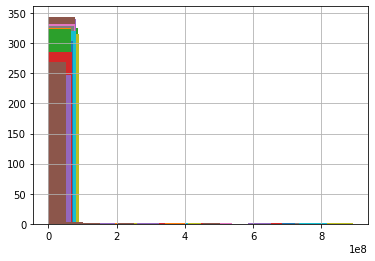

In [ ]:
grouped = df_top.groupby(by=['년', '월', '가맹점소재지1', '가맹점소재지2', '성별', '연령대별', '연평균소득추정', '업종'])

count=0
for name, group in grouped:
  
  count+=1

  print(name)
  group['이용금액'].hist()

count
  

In [ ]:
count=0

print('---')
print('data len: ', len(df_top))

grouped = df_top.groupby(by=['년', '월', '가맹점소재지1','가맹점소재지2','성별','연령대별','연평균소득추정', '업종'])

all_data = []

for name, group in grouped:

  input = np.log1p(pd.DataFrame(group['이용금액'])) # 로그 변환한 이용금액 col
  Outliers_to_drop = detect_outliers(input, ["이용금액"]) # outlier 의 index

  count += len(Outliers_to_drop)

  dropped = pd.DataFrame(group['이용금액']).drop(Outliers_to_drop, axis = 0) # outlier 삭제된 이용금액 col (원본 index 유지)
  group_ = group.drop(columns=['이용금액'])

  all_data.append(   pd.concat([group_, dropped],axis=1, join='inner')   )

print('outlier 개수: ', count)

df_outliered = pd.concat(all_data, axis=0) # ignore_index=True
df_outliered = df_outliered.reset_index()
df_outliered

---
data len:  5104
outlier 개수:  139


,index,년,월,가맹점소재지1,가맹점소재지2,성별,연령대별,연평균소득추정,이용건수,업종,이용금액
0,284900,2019,1,서울특별시,강남구,여성,40대,B4,14,개인미용,1412075.0
1,284910,2019,1,서울특별시,강남구,여성,40대,B4,8,개인미용,1339800.0
2,285146,2019,1,서울특별시,강남구,여성,40대,B4,58,개인미용,1062400.0
3,286670,2019,1,서울특별시,강남구,여성,40대,B4,6,개인미용,3035000.0
4,286671,2019,1,서울특별시,강남구,여성,40대,B4,18,개인미용,10250000.0
...,...,...,...,...,...,...,...,...,...,...,...
4960,87093413,2020,4,서울특별시,강남구,여성,40대,B4,6,개인미용,775000.0
4961,87093415,2020,4,서울특별시,강남구,여성,40대,B4,10,개인미용,702600.0
4962,87093416,2020,4,서울특별시,강남구,여성,40대,B4,42,개인미용,11552640.0
4963,87095154,2020,4,서울특별시,강남구,여성,40대,B4,4,개인미용,332000.0


## 코드 맞나 검사

In [ ]:
fake = [1,1,1,1,1,1,10000000000000000,10000000000000000,1,1]
df = pd.DataFrame(fake, columns=['col'])
df

,col
0,1
1,1
2,1
3,1
4,1
5,1
6,10000000000000000
7,10000000000000000
8,1
9,1


In [ ]:
detect_outliers(df, ["col"])

[6, 7]

In [ ]:
Q1 = np.percentile(df['col'], 25) # 1
Q3 = np.percentile(df['col'], 75) # 1
IQR = Q3 - Q1 # 0

In [ ]:
outlier_step = 1.5 * IQR # 0

In [ ]:
outlier_list_col = df[(df['col'] < Q1 - outlier_step) | (df['col'] > Q3 + outlier_step)].index
outlier_list_col

Int64Index([6, 7], dtype='int64')

In [ ]:
outlier_indices = []
outlier_indices.extend(outlier_list_col)
outlier_indices

[6, 7]

In [ ]:
outlier_indices = Counter(outlier_indices)
outlier_indices

Counter({6: 1, 7: 1})

In [ ]:
multiple_outliers = list(k for k, v in outlier_indices.items() if v > 2)
multiple_outliers

[]

In [ ]:
for k, v in outlier_indices.items():
  print(k)
  print(v)
  print('--')

6
1
--
7
1
--


In [ ]:
list(k for k, v in outlier_indices.items())

[6, 7]